In [98]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pickle
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

import os
import glob

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

### Load Table

In [99]:
# pickle에서 데이터프레임 다시 불러오기
with open('data.pickle', 'rb') as f:
    df = pickle.load(f)

In [100]:
train_path = '../../data/train.csv'
test_path  = '../../data/test.csv'
dt_train = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_train['is_test'] = 0
dt_test['is_test'] = 1
dt = pd.concat([dt_train, dt_test])

In [101]:
extra_data_path = '../yoon/extra_data/'

In [102]:
print(extra_data_path)
os.getcwd()


../yoon/extra_data/


'/root/upstage-ml-regression-3/Sh'

In [103]:
df['large_std_동'] = df['동']
df.drop(['동'], axis=1, inplace=True)

In [104]:
dt['동'] = dt['시군구'].apply(lambda x:x.split()[2])

In [105]:
dt = dt.reset_index()

In [106]:
df['동'] = dt['동']

In [107]:
df[df['아파트명']=='PH129']

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,계약일,date,large_std_동,동
224566,129,129.0,PH129,273.96,202111,10,2020,압구정로79길 88,929070.0,0,강남구,2021,11,854851.724138,25,2021-11-25,청담동,청담동
224567,129,129.0,PH129,273.96,202204,16,2020,압구정로79길 88,1450000.0,0,강남구,2022,04,854851.724138,28,2022-04-28,청담동,청담동
241238,129,129.0,PH129,273.96,202103,14,2020,압구정로79길 88,1150000.0,0,강남구,2021,03,854851.724138,4,2021-03-04,청담동,청담동
241239,129,129.0,PH129,273.96,202107,6,2020,압구정로79길 88,1000000.0,0,강남구,2021,07,854851.724138,7,2021-07-07,청담동,청담동


In [108]:
# df = df.drop(index =[224566,224567,241238,241239])

df

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,계약일,date,large_std_동,동
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,12,120960.000000,8,2017-12-08,개포동,개포동
1,658-1,658.0,개포6차우성,79.97,201712,4,1987,언주로 3,123500.0,0,강남구,2017,12,120960.000000,22,2017-12-22,개포동,개포동
2,658-1,658.0,개포6차우성,54.98,201712,5,1987,언주로 3,91500.0,0,강남구,2017,12,120960.000000,28,2017-12-28,개포동,개포동
3,658-1,658.0,개포6차우성,79.97,201801,4,1987,언주로 3,130000.0,0,강남구,2018,01,120960.000000,3,2018-01-03,개포동,개포동
4,658-1,658.0,개포6차우성,79.97,201801,2,1987,언주로 3,117000.0,0,강남구,2018,01,120960.000000,8,2018-01-08,개포동,개포동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,816.0,신내우디안1단지,84.65,202307,13,2014,신내역로1길 85,NaN,1,중랑구,2023,07,39021.326676,19,2023-07-19,Unknown,신내동
1128090,816,816.0,신내우디안1단지,84.62,202307,12,2014,신내역로1길 85,NaN,1,중랑구,2023,07,39021.326676,25,2023-07-25,Unknown,신내동
1128091,816,816.0,신내우디안1단지,101.65,202308,12,2014,신내역로1길 85,NaN,1,중랑구,2023,08,39021.326676,27,2023-08-27,Unknown,신내동
1128092,816,816.0,신내우디안1단지,84.94,202309,18,2014,신내역로1길 85,NaN,1,중랑구,2023,09,39021.326676,2,2023-09-02,Unknown,신내동


### 년도에따라 동, 구별 statistics 추가

<Axes: xlabel='target', ylabel='Density'>

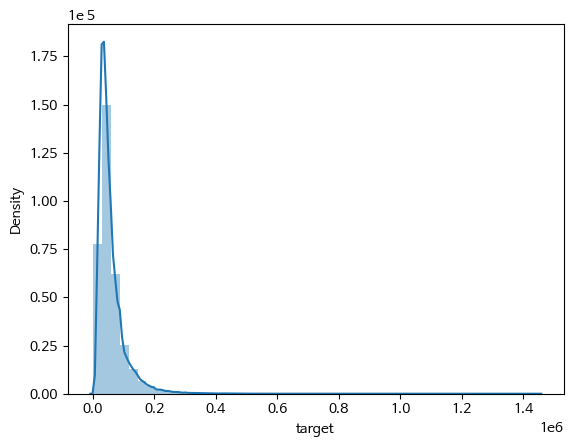

In [109]:
# df.drop(['아파트명'], axis=1, inplace=True)
sns.distplot(df.loc[:,'target'])

In [110]:
df

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,계약일,date,large_std_동,동
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,12,120960.000000,8,2017-12-08,개포동,개포동
1,658-1,658.0,개포6차우성,79.97,201712,4,1987,언주로 3,123500.0,0,강남구,2017,12,120960.000000,22,2017-12-22,개포동,개포동
2,658-1,658.0,개포6차우성,54.98,201712,5,1987,언주로 3,91500.0,0,강남구,2017,12,120960.000000,28,2017-12-28,개포동,개포동
3,658-1,658.0,개포6차우성,79.97,201801,4,1987,언주로 3,130000.0,0,강남구,2018,01,120960.000000,3,2018-01-03,개포동,개포동
4,658-1,658.0,개포6차우성,79.97,201801,2,1987,언주로 3,117000.0,0,강남구,2018,01,120960.000000,8,2018-01-08,개포동,개포동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,816.0,신내우디안1단지,84.65,202307,13,2014,신내역로1길 85,NaN,1,중랑구,2023,07,39021.326676,19,2023-07-19,Unknown,신내동
1128090,816,816.0,신내우디안1단지,84.62,202307,12,2014,신내역로1길 85,NaN,1,중랑구,2023,07,39021.326676,25,2023-07-25,Unknown,신내동
1128091,816,816.0,신내우디안1단지,101.65,202308,12,2014,신내역로1길 85,NaN,1,중랑구,2023,08,39021.326676,27,2023-08-27,Unknown,신내동
1128092,816,816.0,신내우디안1단지,84.94,202309,18,2014,신내역로1길 85,NaN,1,중랑구,2023,09,39021.326676,2,2023-09-02,Unknown,신내동


In [111]:
#아파트명 csv로 보기.
# s_df = df[df.target>=270000]
# apt= s_df['아파트명'].value_counts()
# apt

# apt2 = pd.DataFrame({'아파트명': apt.index, 'num':apt.values})



# apt2.to_csv('apt2.csv', index=False)

<Axes: xlabel='target', ylabel='Density'>

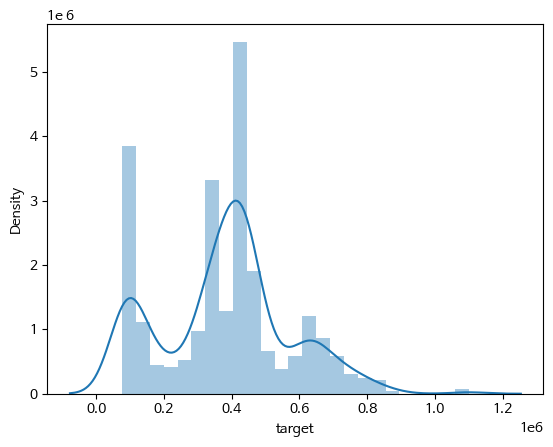

In [112]:
#문제의 한남 더 힐 분포 보기

hn = df[df['아파트명']=='한남더힐']

sns.distplot(hn.loc[:,'target'])



In [113]:
stats = df.groupby(['계약년', '구'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '구'], rsuffix='_target')

In [114]:
df['계약년과구에따른std'] = df['std']
df['계약년과구에따른mean'] = df['mean']
df['계약년과구에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,...,계약년,계약월,평균공시가격,계약일,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,...,2017,12,120960.0,8,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0


In [115]:
stats = df.groupby(['계약년', '동'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '동'], rsuffix='_target')

In [116]:
df['계약년과동에따른std'] = df['std']
df['계약년과동에따른mean'] = df['mean']
df['계약년과동에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,...,계약일,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,...,8,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0,32126.755612,108070.249556,260000.0


In [117]:
# '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
df['계약년과동에따른std'] = df['계약년과동에따른std'].fillna(df['계약년과구에따른std'])
df['계약년과동에따른mean'] = df['계약년과동에따른mean'].fillna(df['계약년과구에따른mean'])
df['계약년과동에따른max'] = df['계약년과동에따른max'].fillna(df['계약년과구에따른max'])

In [118]:
df.drop(['구', 'large_std_동', 'date', '본번', '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'], axis=1, inplace=True)

In [119]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '계약년', '계약월', '평균공시가격', '계약일', '동', '계약년과동에따른std',
       '계약년과동에따른mean', '계약년과동에따른max'],
      dtype='object')

In [120]:
df['건축년도'].dtype

dtype('int64')

In [121]:
df['계약년월'].dtype

dtype('int64')

In [122]:
df['yrs_diff'] = df['계약년월'].map(lambda x : x // 100) - df['건축년도']

In [123]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '계약년', '계약월', '평균공시가격', '계약일', '동', '계약년과동에따른std',
       '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff'],
      dtype='object')

In [124]:
# Use glob to find all files that match the pattern
file_paths = glob.glob(extra_data_path + "/KOSPI_*.csv")


# Initialize an empty list to store the dataframes
dfs = []

# Iterate over the file paths and read each CSV file into a dataframe
for file_path in file_paths:
    kospi_df_yr = pd.read_csv(file_path, encoding="euc-kr")
    dfs.append(kospi_df_yr)

kospi_df = pd.concat(dfs, ignore_index=True)
kospi_df = kospi_df.drop(columns=['시가', '고가', '저가'])

In [125]:
kospi_df.rename(columns={"일자":"date", "종가":"Close"}, inplace=True)
kospi_df["date"] = kospi_df['date'].str.replace('/', '-')
kospi_df["date"] = pd.to_datetime(kospi_df["date"])
kospi_df.sort_values(by='date', ascending=True, inplace=True)

In [126]:
kospi_df["Close_delay120d"] = kospi_df["Close"].shift(120)

In [127]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '계약년', '계약월', '평균공시가격', '계약일', '동', '계약년과동에따른std',
       '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff'],
      dtype='object')

In [128]:
df['date'] = pd.to_datetime(df['계약년'].astype(str) + '-' + df['계약월'].astype(str) + '-' + df['계약일'].astype(str))

In [129]:
df = pd.merge(left=df, right=kospi_df, on='date', how='left')

In [130]:
df.drop(columns=['date', 'Close', '대비', '등락률', '거래량', '거래대금', '상장시가총액'], inplace=True)

In [131]:
df["Close_delay120d"] = df["Close_delay120d"].interpolate(method='linear', axis=0)

In [132]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '계약년', '계약월', '평균공시가격', '계약일', '동', '계약년과동에따른std',
       '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff', 'Close_delay120d'],
      dtype='object')

In [133]:
df.drop(columns=['계약년', '계약월', '계약일'], inplace=True)

In [134]:
df = df[df['계약년월']>=201501]
df.sort_values(by='계약년월')

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
701077,336,장안현대홈타운,84.87,201501,14,2003,장안벚꽃로 107,43300.0,0,47463.663220,장안동,9339.081397,38387.940039,75900.0,12,2006.905000
720907,1500,금호삼성래미안,59.95,201501,12,2001,독서당로 343,40600.0,0,71502.749141,금호동1가,7498.316902,44702.148760,62000.0,14,2026.620000
720908,1500,금호삼성래미안,59.95,201501,8,2001,독서당로 343,40000.0,0,71502.749141,금호동1가,7498.316902,44702.148760,62000.0,14,2048.810000
668322,1158,우장산에스케이뷰,84.97,201501,8,2006,우현로 26,41000.0,0,48647.290640,화곡동,18485.524203,39325.281856,90198.0,9,2031.555000
668321,1158,우장산에스케이뷰,84.97,201501,4,2006,우현로 26,41300.0,0,48647.290640,화곡동,18485.524203,39325.281856,90198.0,9,2021.203333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121532,1002-1,럭키남서울,41.22,202309,7,1981,시흥대로47길 43,NaN,1,37601.724138,시흥동,18739.666871,54811.864407,102500.0,42,2395.690000
1121524,1013,관악산벽산타운5,59.34,202309,19,2004,금하로 816,NaN,1,34454.448399,시흥동,18739.666871,54811.864407,102500.0,19,2404.853333
1121523,1013,관악산벽산타운5,84.97,202309,19,2004,금하로 816,NaN,1,34454.448399,시흥동,18739.666871,54811.864407,102500.0,19,2392.026667
1125986,163-14,현대,59.91,202309,1,1997,오금로32길 42,NaN,1,64433.744856,송파동,27461.131123,135602.941176,210000.0,26,2405.486667


<Axes: xlabel='target', ylabel='Density'>

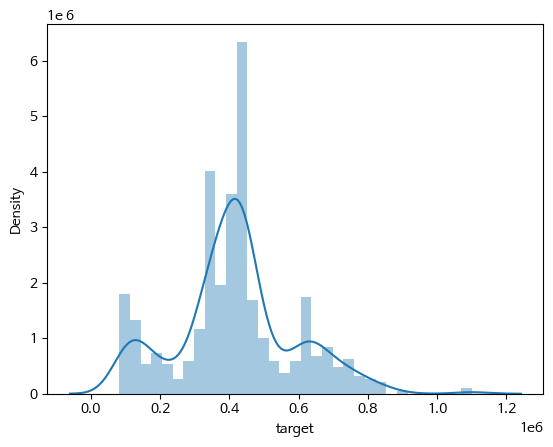

In [135]:
#문제의 한남더힐
hn=df[df['아파트명']=='한남더힐']
sns.distplot(hn.loc[:, 'target'])

In [136]:
df[df.target>=500000]['아파트명'].value_counts()

한남더힐           134
반포주공1단지         33
반포자이            27
래미안퍼스티지         26
아크로리버파크         24
              ... 
상지리츠빌장충동카일룸      1
디에이치아너힐즈         1
개포우성1            1
래미안라클래시          1
논현라폴리움           1
Name: 아파트명, Length: 63, dtype: int64

In [137]:
df[(df.target>=800000) & (df.target<1000000)]

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
203590,128-18,상지리츠빌카일룸2차,244.3200,202303,5,2006,압구정로79길 87,821000.0,0,548860.000000,청담동,182535.447641,318581.395349,900000.0,17,2478.645
203591,128-18,상지리츠빌카일룸2차,244.3200,202305,16,2006,압구정로79길 87,900000.0,0,548860.000000,청담동,182535.447641,318581.395349,900000.0,17,2477.450
212646,18-1,래미안퍼스티지,222.7600,202211,22,2009,반포대로 275,840000.0,0,269199.631751,반포동,169468.123486,404819.448718,840000.0,13,2670.650
212662,18-1,래미안퍼스티지,222.7600,202304,25,2009,반포대로 275,810000.0,0,269199.631751,반포동,135631.866397,298195.588235,810000.0,14,2219.710
221948,829,나인원한남,206.8953,202211,8,2019,한남대로 91,945000.0,0,641836.656891,한남동,354143.419439,416847.500000,1350000.0,3,2550.080
221949,829,나인원한남,206.8953,202306,6,2019,한남대로 91,900000.0,0,641836.656891,한남동,279436.203653,334323.529412,1100000.0,4,2225.670
223824,467,타워팰리스1,301.4700,202205,56,2002,언주로30길 56,870000.0,0,249403.872967,도곡동,147611.133785,269415.363636,870000.0,20,2997.210
224097,369-1,현대1차,196.2100,202201,9,1976,압구정로29길 71,800000.0,0,375159.791667,압구정동,118147.086900,450217.948718,800000.0,46,3254.420
224102,369-1,현대1차,196.2100,202207,6,1976,압구정로29길 71,800000.0,0,375159.791667,압구정동,118147.086900,450217.948718,800000.0,46,2926.720
224566,129,PH129,273.9600,202111,10,2020,압구정로79길 88,929070.0,0,854851.724138,청담동,199738.445661,277167.682927,1150000.0,1,3224.230


In [138]:
df[(df.target>=500000) & (df.target<800000)]['아파트명'].unique()

array(['타워팰리스1', '아이파크', '현대7차', '마크힐스이스트윙', '상지리츠빌카일룸2차', '상지카일룸',
       '한남더힐', '한보미도맨션2', '상지리츠빌카일룸', '타워팰리스2', '압구정하이츠파크', '신현대11차',
       '신현대12차', '한양4', '현대1차', '현대2차', '현대6차', '현대8차', '동양파라곤', '빌폴라리스',
       '이니그마빌', '청담어퍼하우스', '래미안퍼스티지', '반포자이', '레베빌', '반포주공1단지', '트라움하우스3',
       '띠에라하우스', '아크로서울포레스트', '한강맨숀', '도곡렉슬', '상지리츠빌장충동카일룸', '디에이치아너힐즈',
       '개포우성1', '동부센트레빌', '래미안대치팰리스', '타워팰리스3', '힐데스하임빌라', '래미안라클래시',
       '삼성동헤렌하우스2', '아펠바움', '마크힐스웨스트윙', '연세리버빌3', '효성빌라청담101', '메세나폴리스',
       '아크로리버파크', '트리마제', '갤러리아포레', '서울', '래미안첼리투스', '로덴하우스이스트빌리지',
       '미성1차', '한양8', '용산파크타워', '용산시티파크', '나인원한남', '로덴하우스웨스트빌리지',
       '이니그마빌2', '상지리츠빌카일룸3차', '논현라폴리움'], dtype=object)

In [139]:
df[df['아파트명']=='압구정하이츠파크']

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
2311,632,압구정하이츠파크,184.02,201711,21,2004,압구정로42길 78,279000.0,0,311306.976744,신사동,36992.585634,44917.392405,325000.0,13,2371.720000
2312,632,압구정하이츠파크,184.02,201802,13,2004,압구정로42길 78,295000.0,0,311306.976744,신사동,37805.448121,45781.070560,350000.0,14,2319.710000
2313,632,압구정하이츠파크,184.02,201802,19,2004,압구정로42길 78,300000.0,0,311306.976744,신사동,37805.448121,45781.070560,350000.0,14,2361.670000
2314,632,압구정하이츠파크,213.05,201802,7,2004,압구정로42길 78,300000.0,0,311306.976744,신사동,37805.448121,45781.070560,350000.0,14,2378.510000
2315,632,압구정하이츠파크,184.02,201809,12,2004,압구정로42길 78,350000.0,0,311306.976744,신사동,37805.448121,45781.070560,350000.0,14,2255.915000
202790,632,압구정하이츠파크,213.05,202303,20,2004,압구정로42길 78,600000.0,0,311306.976744,신사동,112910.218306,85902.777778,600000.0,19,2332.310000
202791,632,압구정하이츠파크,184.02,202304,6,2004,압구정로42길 78,500000.0,0,311306.976744,신사동,112910.218306,85902.777778,600000.0,19,2249.950000
202792,632,압구정하이츠파크,184.02,202304,4,2004,압구정로42길 78,500000.0,0,311306.976744,신사동,112910.218306,85902.777778,600000.0,19,2288.780000
222779,632,압구정하이츠파크,213.05,202201,19,2004,압구정로42길 78,550000.0,0,311306.976744,신사동,70270.101283,63383.766234,550000.0,18,3244.040000
238588,632,압구정하이츠파크,213.05,202010,14,2004,압구정로42길 78,445000.0,0,311306.976744,신사동,43968.120518,56044.777563,450000.0,16,2244.296667


In [140]:


dt_test[dt_test['아파트명'] =='나인원한남']

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,is_test


In [141]:
df[df['도로명']=='영동대로 640'].target.mean()

376448.05194805196

In [142]:
apt = dt_test['아파트명'].value_counts()

apt2 = pd.DataFrame({'아파트명': apt.index, 'num':apt.values})



apt2.to_csv('apt2.csv', index=False)

### Feature Engineering

### Train

In [143]:
# is_20000 = True

In [144]:
# if is_20000:
#     df['계약년월']= df['계약년월'] - 200000
#     is_20000 = False
# df

In [145]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

# df_train.drop(['is_test'], axis=1, inplace=True)
# df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(636736, 16) (9272, 16)


In [146]:
doro = df_train.groupby('도로명')['target'].mean()

doro2 = pd.DataFrame({'아파트명': doro.index, 'num':doro.values.round(2)})



doro2.to_csv('doro2.csv', index=False)



In [147]:
doro3=doro2[doro2.num>=200000]

<Axes: xlabel='num', ylabel='Density'>

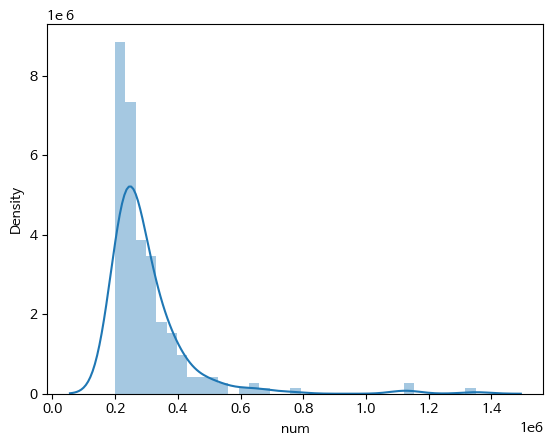

In [148]:
sns.distplot(doro3.loc[:,'num'])

In [149]:
doro3['아파트명'].unique()

df[df['도로명']=='개포로 264']

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
201180,1282,개포래미안포레스트,84.83,202211,33,2020,개포로 264,240000.0,0,149270.905923,개포동,100307.493033,213071.212121,590000.0,2,2658.99
201181,1282,개포래미안포레스트,84.86,202211,5,2020,개포로 264,240000.0,0,149270.905923,개포동,100307.493033,213071.212121,590000.0,2,2626.34
201182,1282,개포래미안포레스트,59.92,202301,13,2020,개포로 264,158000.0,0,149270.905923,개포동,65335.877082,169735.593220,370000.0,3,2328.61
201183,1282,개포래미안포레스트,59.92,202301,13,2020,개포로 264,166000.0,0,149270.905923,개포동,65335.877082,169735.593220,370000.0,3,2381.94
201184,1282,개포래미안포레스트,59.92,202301,12,2020,개포로 264,167000.0,0,149270.905923,개포동,65335.877082,169735.593220,370000.0,3,2435.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118897,1282,개포래미안포레스트,84.86,202308,11,2020,개포로 264,NaN,1,149270.905923,개포동,65335.877082,169735.593220,370000.0,3,2432.07
1118898,1282,개포래미안포레스트,84.86,202308,15,2020,개포로 264,NaN,1,149270.905923,개포동,65335.877082,169735.593220,370000.0,3,2462.62
1118899,1282,개포래미안포레스트,74.66,202308,16,2020,개포로 264,NaN,1,149270.905923,개포동,65335.877082,169735.593220,370000.0,3,2419.09
1118900,1282,개포래미안포레스트,59.92,202309,13,2020,개포로 264,NaN,1,149270.905923,개포동,65335.877082,169735.593220,370000.0,3,2395.69


In [150]:
df[df['도로명']=='압구정로79길 76']

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
5135,129-7,빌폴라리스,166.01,201807,10,2009,압구정로79길 76,350000.0,0,335478.947368,청담동,99841.781862,175336.270492,640000.0,9,2562.230
203586,129-7,빌폴라리스,166.01,202303,2,2009,압구정로79길 76,485000.0,0,335478.947368,청담동,182535.447641,318581.395349,900000.0,14,2376.460
203587,129-7,빌폴라리스,166.01,202305,11,2009,압구정로79길 76,570000.0,0,335478.947368,청담동,182535.447641,318581.395349,900000.0,14,2444.480
224579,129-7,빌폴라리스,166.01,202111,17,2009,압구정로79길 76,516500.0,0,335478.947368,청담동,199738.445661,277167.682927,1150000.0,12,3188.730
241260,129-7,빌폴라리스,166.01,202107,20,2009,압구정로79길 76,490000.0,0,335478.947368,청담동,199738.445661,277167.682927,1150000.0,12,3148.290
298607,129-7,빌폴라리스,166.01,201911,19,2009,압구정로79길 76,438000.0,0,335478.947368,청담동,88395.575302,199207.321429,645000.0,10,2061.250
394183,129-7,빌폴라리스,166.01,201905,9,2009,압구정로79길 76,340000.0,0,335478.947368,청담동,88395.575302,199207.321429,645000.0,10,2078.690
447832,129-7,빌폴라리스,166.01,201701,2,2009,압구정로79길 76,345000.0,0,335478.947368,청담동,69467.300750,142109.196319,570000.0,8,1994.790
447833,129-7,빌폴라리스,166.01,201706,13,2009,압구정로79길 76,370000.0,0,335478.947368,청담동,69467.300750,142109.196319,570000.0,8,2021.785
447834,129-7,빌폴라리스,166.01,201707,16,2009,압구정로79길 76,380000.0,0,335478.947368,청담동,69467.300750,142109.196319,570000.0,8,2048.780


In [151]:
drop_apt = df.groupby('도로명')['is_test'].sum()
drop_apt

도로명
             3
 10          0
 174-2       0
 18          0
 20          0
            ..
희우정로17길 9    0
희우정로1길 21    0
희우정로1길 27    0
희우정로1길 48    0
희우정로21길 5    0
Name: is_test, Length: 9048, dtype: int64

In [152]:
drop_apt2 = pd.DataFrame({'도로명':drop_apt.index, 'num':drop_apt.values})
drop_apt2

drop_apt_name = drop_apt2[drop_apt2.num==0]['도로명'].unique()
print(len(drop_apt_name))
drop_apt_name


6406


array([' 10', ' 174-2', ' 18', ..., '희우정로1길 27', '희우정로1길 48', '희우정로21길 5'],
      dtype=object)

In [153]:
drop_index = df[df['도로명'].isin(drop_apt_name)].index

print(len(drop_index))

df.drop(index=drop_index)

152542


,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
0,658-1,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2372.640000
1,658-1,개포6차우성,79.97,201712,4,1987,언주로 3,123500.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2382.560000
2,658-1,개포6차우성,54.98,201712,5,1987,언주로 3,91500.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2394.480000
3,658-1,개포6차우성,79.97,201801,4,1987,언주로 3,130000.0,0,120960.000000,개포동,43598.058342,142378.337531,260000.0,31,2388.350000
4,658-1,개포6차우성,79.97,201801,2,1987,언주로 3,117000.0,0,120960.000000,개포동,43598.058342,142378.337531,260000.0,31,2382.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,신내우디안1단지,84.65,202307,13,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2428.570000
1128090,816,신내우디안1단지,84.62,202307,12,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2425.080000
1128091,816,신내우디안1단지,101.65,202308,12,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2420.253333
1128092,816,신내우디안1단지,84.94,202309,18,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2415.426667


In [154]:
df[df['도로명']=="개포로109길 69"]

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
25,12-2,개포자이,153.80,201710,19,2004,개포로109길 69,146000.0,0,167831.132075,개포동,32126.755612,108070.249556,260000.0,13,2128.91
26,12-2,개포자이,170.32,201710,2,2004,개포로109길 69,144500.0,0,167831.132075,개포동,32126.755612,108070.249556,260000.0,13,2173.74
27,12-2,개포자이,134.30,201711,4,2004,개포로109길 69,152000.0,0,167831.132075,개포동,32126.755612,108070.249556,260000.0,13,2270.12
28,12-2,개포자이,153.80,201711,1,2004,개포로109길 69,142000.0,0,167831.132075,개포동,32126.755612,108070.249556,260000.0,13,2296.37
29,12-2,개포자이,170.32,201801,16,2004,개포로109길 69,162000.0,0,167831.132075,개포동,43598.058342,142378.337531,260000.0,14,2380.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643871,12-2,개포자이,153.80,201506,7,2004,개포로109길 69,136000.0,0,167831.132075,개포동,22875.834782,74059.179739,167000.0,11,1986.61
643872,12-2,개포자이,134.30,201506,10,2004,개포로109길 69,118900.0,0,167831.132075,개포동,22875.834782,74059.179739,167000.0,11,1916.59
643873,12-2,개포자이,168.42,201506,22,2004,개포로109길 69,144250.0,0,167831.132075,개포동,22875.834782,74059.179739,167000.0,11,1915.75
643874,12-2,개포자이,153.80,201507,14,2004,개포로109길 69,144000.0,0,167831.132075,개포동,22875.834782,74059.179739,167000.0,11,1952.84


In [155]:
#약 117개 index
#하지만 이촌동이 약 4100개 있어서 그냥 지우기로 생각함.
# 4천개만으로도 충분히 예측 가능할 것 같고, 이 래미안첼리투스는 
# 공시가격이 26억인데 50억 거래된 것이 있어서 순간 튄 값이 보임.
df[df['도로명']=="영동대로142길 21"]

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
224576,130-6,마크힐스웨스트윙,183.5,202202,6,2010,영동대로142길 21,570000.0,0,436868.421053,청담동,230216.769107,249733.258065,1450000.0,12,3144.19
241256,130-6,마크힐스웨스트윙,183.5,202105,17,2010,영동대로142길 21,560000.0,0,436868.421053,청담동,199738.445661,277167.682927,1150000.0,11,2617.76
550217,130-6,마크힐스웨스트윙,183.5,201605,2,2010,영동대로142길 21,455000.0,0,436868.421053,청담동,66388.633363,126849.264368,515000.0,6,2023.93
652560,130-6,마크힐스웨스트윙,183.5,201505,12,2010,영동대로142길 21,430000.0,0,436868.421053,청담동,62521.945025,112884.528972,474000.0,5,1978.54


In [156]:
# df[df['동']=='']
# 한강로 3가는 400개 index
# 용산 시티파크는 150개의 index라서 지우지 않았음.

df[df['아파트명']=="나인원한남"] 


,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
221948,829,나인원한남,206.8953,202211,8,2019,한남대로 91,945000.0,0,641836.656891,한남동,354143.419439,416847.500000,1350000.0,3,2550.08
221949,829,나인원한남,206.8953,202306,6,2019,한남대로 91,900000.0,0,641836.656891,한남동,279436.203653,334323.529412,1100000.0,4,2225.67
236646,829,나인원한남,273.4125,202110,1,2019,한남대로 91,840000.0,0,641836.656891,한남동,284088.039234,297951.973684,1200000.0,2,3198.84
236647,829,나인원한남,244.3478,202112,2,2019,한남대로 91,900000.0,0,641836.656891,한남동,284088.039234,297951.973684,1200000.0,2,3216.18
236648,829,나인원한남,206.8953,202203,8,2019,한남대로 91,850000.0,0,641836.656891,한남동,354143.419439,416847.500000,1350000.0,3,3133.64
288719,829,나인원한남,244.3478,202103,3,2019,한남대로 91,730000.0,0,641836.656891,한남동,284088.039234,297951.973684,1200000.0,2,2412.40
288720,829,나인원한남,244.3478,202104,4,2019,한남대로 91,790000.0,0,641836.656891,한남동,284088.039234,297951.973684,1200000.0,2,2343.31
288721,829,나인원한남,206.8953,202105,4,2019,한남대로 91,650000.0,0,641836.656891,한남동,284088.039234,297951.973684,1200000.0,2,2416.50
288722,829,나인원한남,206.8953,202105,4,2019,한남대로 91,670000.0,0,641836.656891,한남동,284088.039234,297951.973684,1200000.0,2,2539.15
288723,829,나인원한남,206.8953,202105,7,2019,한남대로 91,630000.0,0,641836.656891,한남동,284088.039234,297951.973684,1200000.0,2,2545.64


In [157]:
aptname = dt_train['아파트명'].unique()

In [158]:
dt_test[~dt_test['아파트명'].isin(aptname)]['아파트명'].unique()

array(['역삼센트럴2차아이파크', '힐데스하임천호', '아츠스테이수유점', '수유시그니티', '더헤리츠', '흑석리버파크자이',
       '신수동르끌레브', '르엘신반포파크애비뉴', '히페리온리버팰리스', '세운푸르지오헤리시티',
       '힐스테이트세운센트럴1단지'], dtype=object)

In [159]:
dt_train[dt_train['아파트명']=='힐데스하임천호']

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test


In [160]:
df[df['아파트명']=='힐스테이트세운센트럴1단지']

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
1127872,277,힐스테이트세운센트럴1단지,25.0654,202307,17,2023,을지로15길 31,NaN,1,13822.687075,입정동,61652.639417,81300.0,81300.0,0,2425.08


In [161]:
df[df['동']=='신수동']

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
51361,453,대원칸타빌,117.183,201711,6,2004,창전로2길 10,80000.0,0,78290.681004,신수동,10834.735643,58173.381295,80000.0,13,2433.305
51362,453,대원칸타빌,117.183,201712,4,2004,창전로2길 10,77500.0,0,78290.681004,신수동,10834.735643,58173.381295,80000.0,13,2372.640
51363,453,대원칸타빌,117.183,201801,4,2004,창전로2길 10,83000.0,0,78290.681004,신수동,16194.263208,74621.929825,125000.0,14,2400.135
51364,453,대원칸타빌,143.656,201801,19,2004,창전로2길 10,79000.0,0,78290.681004,신수동,16194.263208,74621.929825,125000.0,14,2427.630
51365,453,대원칸타빌,117.183,201802,14,2004,창전로2길 10,83500.0,0,78290.681004,신수동,16194.263208,74621.929825,125000.0,14,2395.450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123569,462,신촌숲아이파크,84.912,202309,15,2019,광성로 17,NaN,1,101599.310345,신수동,31586.461754,121444.736842,174500.0,4,2394.590
1123570,462,신촌숲아이파크,84.932,202309,12,2019,광성로 17,NaN,1,101599.310345,신수동,31586.461754,121444.736842,174500.0,4,2371.780
1123571,462,신촌숲아이파크,59.376,202309,22,2019,광성로 17,NaN,1,101599.310345,신수동,31586.461754,121444.736842,174500.0,4,2348.970
1123572,462,신촌숲아이파크,59.376,202309,29,2019,광성로 17,NaN,1,101599.310345,신수동,31586.461754,121444.736842,174500.0,4,2416.960


In [162]:
df[df['target']>=1000000]

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
221261,810,한남더힐,240.305,202303,5,2011,독서당로 111,1100000.0,0,473542.166667,한남동,279436.203653,334323.529412,1100000.0,12,2401.830
224567,129,PH129,273.960,202204,16,2020,압구정로79길 88,1450000.0,0,854851.724138,청담동,230216.769107,249733.258065,1450000.0,2,2975.710
233420,685-700,아크로서울포레스트,264.546,202209,47,2020,왕십리로 83-21,1300000.0,0,423578.928571,성수동1가,262281.567769,300048.809524,1300000.0,2,2695.860
236258,810,한남더힐,240.305,202205,3,2011,독서당로 111,1100000.0,0,473542.166667,한남동,354143.419439,416847.500000,1350000.0,11,2945.270
236660,410,파르크한남,268.950,202111,3,2020,유엔빌리지길 80-1,1150000.0,0,324238.544892,한남동,284088.039234,297951.973684,1200000.0,1,3221.870
236661,410,파르크한남,268.670,202111,4,2020,유엔빌리지길 80-1,1170000.0,0,478113.931889,한남동,284088.039234,297951.973684,1200000.0,1,3247.430
236662,410,파르크한남,268.950,202112,2,2020,유엔빌리지길 80-1,1200000.0,0,631989.318885,한남동,284088.039234,297951.973684,1200000.0,1,3267.930
236663,410,파르크한남,268.670,202204,5,2020,유엔빌리지길 80-36,1350000.0,0,785864.705882,한남동,354143.419439,416847.500000,1350000.0,2,3197.565
241238,129,PH129,273.960,202103,14,2020,압구정로79길 88,1150000.0,0,854851.724138,청담동,199738.445661,277167.682927,1150000.0,1,2395.900
241239,129,PH129,273.960,202107,6,2020,압구정로79길 88,1000000.0,0,854851.724138,청담동,199738.445661,277167.682927,1150000.0,1,3148.290


In [163]:
ip=df[df['도로명']== '영동대로 640']
ip[(ip['계약년월'] >= 201801) & (ip['계약년월'] <= 202301)]

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
3100,87,아이파크,145.046,201801,26,2004,영동대로 640,328000.0,0,385492.650334,삼성동,86500.857136,172303.000000,620000.0,14,2382.330
3101,87,아이파크,175.052,201801,7,2004,영동대로 640,388000.0,0,385492.650334,삼성동,86500.857136,172303.000000,620000.0,14,2382.100
3102,87,아이파크,145.046,201801,20,2004,영동대로 640,328000.0,0,385492.650334,삼성동,86500.857136,172303.000000,620000.0,14,2409.490
3103,87,아이파크,175.052,201801,9,2004,영동대로 640,395000.0,0,385492.650334,삼성동,86500.857136,172303.000000,620000.0,14,2406.100
3104,87,아이파크,156.857,201801,30,2004,영동대로 640,380000.0,0,385492.650334,삼성동,86500.857136,172303.000000,620000.0,14,2402.710
3105,87,아이파크,175.052,201802,14,2004,영동대로 640,390000.0,0,385492.650334,삼성동,86500.857136,172303.000000,620000.0,14,2394.730
3106,87,아이파크,195.388,201806,19,2004,영동대로 640,500000.0,0,385492.650334,삼성동,86500.857136,172303.000000,620000.0,14,2433.110
3107,87,아이파크,156.857,201806,13,2004,영동대로 640,310000.0,0,385492.650334,삼성동,86500.857136,172303.000000,620000.0,14,2471.490
3108,87,아이파크,145.046,201807,2,2004,영동대로 640,303000.0,0,385492.650334,삼성동,86500.857136,172303.000000,620000.0,14,2536.600
3109,87,아이파크,195.388,201808,34,2004,영동대로 640,620000.0,0,385492.650334,삼성동,86500.857136,172303.000000,620000.0,14,2415.120


In [180]:
ip = df[df['도로명']=='영동대로 640']
ip.groupby('전용면적(㎡)')['target'].agg(['mean','max','min']).round(2)

,mean,max,min
전용면적(㎡),,,
145.046,322226.19,560000.0,225000.0
156.857,321276.32,500000.0,233000.0
167.720,362323.53,510000.0,269000.0
175.052,403565.22,600000.0,272000.0
195.388,469890.62,700000.0,345000.0
203.121,1053000.00,1053000.0,1053000.0
226.600,700000.00,700000.0,700000.0


In [184]:
ip[ip.target>=700000]

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
223960,87,아이파크,195.388,202112,3,2004,영동대로 640,700000.0,0,385492.650334,삼성동,132858.542873,193307.043011,700000.0,17,3192.66
296721,87,아이파크,226.600,201911,43,2004,영동대로 640,700000.0,0,385492.650334,삼성동,83628.634270,185188.402062,700000.0,15,2069.11
445597,87,아이파크,203.121,201708,30,2004,영동대로 640,1053000.0,0,385492.650334,삼성동,76936.161778,137984.640981,1053000.0,13,2074.57


In [185]:
ip

,번지,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
3092,87,아이파크,167.720,201710,46,2004,영동대로 640,370000.0,0,385492.650334,삼성동,76936.161778,137984.640981,1053000.0,13,2148.610
3093,87,아이파크,167.720,201710,46,2004,영동대로 640,370000.0,0,385492.650334,삼성동,76936.161778,137984.640981,1053000.0,13,2145.760
3094,87,아이파크,167.720,201710,32,2004,영동대로 640,340000.0,0,385492.650334,삼성동,76936.161778,137984.640981,1053000.0,13,2138.400
3095,87,아이파크,156.857,201711,25,2004,영동대로 640,338000.0,0,385492.650334,삼성동,76936.161778,137984.640981,1053000.0,13,2217.385
3096,87,아이파크,145.046,201711,26,2004,영동대로 640,348000.0,0,385492.650334,삼성동,76936.161778,137984.640981,1053000.0,13,2296.370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649599,87,아이파크,175.052,201509,34,2004,영동대로 640,365000.0,0,385492.650334,삼성동,74950.328327,114173.742210,498000.0,11,2036.590
1119275,87,아이파크,156.857,202307,29,2004,영동대로 640,NaN,1,385492.650334,삼성동,114970.833007,206010.416667,493000.0,19,2468.880
1119276,87,아이파크,175.052,202307,10,2004,영동대로 640,NaN,1,385492.650334,삼성동,114970.833007,206010.416667,493000.0,19,2438.190
1119277,87,아이파크,167.720,202308,2,2004,영동대로 640,NaN,1,385492.650334,삼성동,114970.833007,206010.416667,493000.0,19,2465.640
